# Triples

Created by Kidror

In [164]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("roll_data/*-triples.csv")

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
df['gf_times_batter_vibes'] = df['batter_ground_friction'] * df['batter_vibes']
df['op_times_pitcher_vibes'] = df['pitcher_overpowerment'] * df['pitcher_vibes']

season = 14
df = df[df['season'] == season]
len(df)

5908

In [165]:
dfc = df.copy()
for exclude_mod in ["O_NO", "ON_FIRE", "OVERPERFORMING", "UNDERPERFORMING", "GROWTH", "HIGH_PRESSURE", "SINKING_SHIP", "TRAVELING", "CHUNKY", "SMOOTH"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

batter_params = ['batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon']
pitcher_params = ['pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness', 'pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness', 'pitcher_base_thirst', 'pitcher_continuation', 'pitcher_ground_friction', 'pitcher_indulgence', 'pitcher_laserlikeness', 'pitcher_anticapitalism', 'pitcher_chasiness', 'pitcher_omniscience', 'pitcher_tenaciousness', 'pitcher_watchfulness', 'pitcher_pressurization', 'pitcher_cinnamon']
for attr in batter_params:
    dfc[attr] = dfc[attr] * df['batter_multiplier']
for attr in pitcher_params:
    dfc[attr] = dfc[attr] * df['pitcher_multiplier']

dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0

dfc = dfc[dfc["batter_multiplier"] == 1]
dfc = dfc[dfc["pitcher_multiplier"] == 1]


In [179]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

dfc["gf_vibes"] = dfc["batter_ground_friction"] * (1 + 0.2*dfc["batter_vibes"])
dfc["opw_vibes"] = dfc["pitcher_overpowerment"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["unthwack_vibes"] = dfc["pitcher_unthwackability"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["chase_vibes"] = dfc["fielder_chasiness"] * (1 + 0.2*dfc["fielder_vibes"])
dfc["cold_vibes"] = dfc["pitcher_coldness"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["ruth_vibes"] = dfc["pitcher_ruthlessness"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["shakes_vibes"] = dfc["pitcher_shakespearianism"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["supp_vibes"] = dfc["pitcher_suppression"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["hard"] = dfc["ballpark_forwardness"] + dfc["ballpark_viscosity"] - dfc["ballpark_ominousness"]
dfc["hit"] = dfc["ballpark_grandiosity"] + dfc["ballpark_obtuseness"] - dfc["ballpark_inconvenience"]

X = dfc[["roll", "gf_vibes", "opw_vibes", "chase_vibes"]]
y = dfc['passed']

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, C=10000, max_iter=10000, tol=1e-5).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
confusion_matrix(y,predictionsvm)

array([[2840,   15],
       [  10,  408]], dtype=int64)

In [180]:
print(len(dfc[~dfc["passed"]]))
print(len(dfc[dfc["passed"]]))

2855
418


In [174]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[(1.0, 'roll'),
 (-0.19982407484680775, 'gf_vibes'),
 (0.046730918762836506, 'chase_vibes'),
 (0.042132438915706255, 'opw_vibes'),
 (-0.022751856848919155, 'hit'),
 (-0.004532869205261987, 'hard')]

In [175]:
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
intercept_scaled

array([-0.03441689])

In [176]:
gf = dfc["batter_ground_friction"] * (1 + 0.2*dfc["batter_vibes"])
opw = dfc["pitcher_overpowerment"] * (1 + 0.2*dfc["pitcher_vibes"])
grand = dfc["ballpark_grandiosity"]
vis = dfc["ballpark_viscosity"]
fwd = dfc["ballpark_forwardness"]
omi = dfc["ballpark_ominousness"]
elong = dfc["ballpark_elongation"]
chase = dfc["fielder_chasiness"] * (1 + 0.2*dfc["fielder_vibes"])
cold = dfc["pitcher_coldness"] * (1 + 0.2*dfc["pitcher_vibes"])

# S12 & 13 - 0.05 + 0.2*gf - 0.06*chase - 0.04*opw

dfc["threshold"] = 0.0525 + 0.2*gf - 0.045*chase - 0.0425*opw

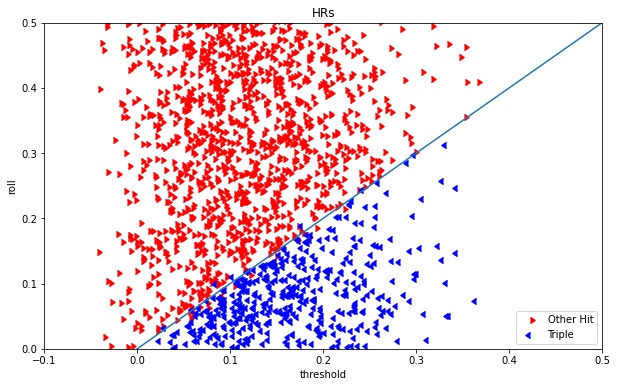

In [177]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="Other Hit", marker=CARETRIGHTBASE)
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Triple", marker=CARETLEFTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("HRs")
ax.set_xlim([-0.1, 0.5])
ax.set_ylim([0.0, 0.5])
ax.legend()

,offset,weather,event_type,batter_multiplier,pitcher_multiplier,roll,threshold,fielder_name,fielder_chasiness,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count
19286,-0.012351,Weather.FLOODING,Hit2,1.0,1.0,0.062265,0.074616,Lotus Mango,0.718092,Adelaide Judochop,Alaynabella Hollywood,NaN,NaN,MAINTENANCE_MODE;STALEPOPCORN_PAYOUTS;PARTY_TIME,PARTY_TIME,92,d329df99-f164-4899-8f91-a93e2e4dd65f,170
14804,-0.012347,Weather.FEEDBACK,Hit2,1.0,1.0,0.171331,0.183678,Oliver Mueller,0.520064,Kichiro Guerra,Alaynabella Hollywood,ALTERNATE;MAXIMALIST,NaN,LOVE,NaN,36,cac35c5e-0464-4962-9930-2a7c25b79bf4,44
19292,-0.012131,Weather.FLOODING,Hit1,1.0,1.0,0.074761,0.086892,Mira Lemma,0.624862,Oliver Notarobot,Shirai McElroy,ALTERNATE,NaN,PARTY_TIME,MAINTENANCE_MODE;STALEPOPCORN_PAYOUTS;PARTY_TIME,92,d329df99-f164-4899-8f91-a93e2e4dd65f,190
15457,-0.007943,Weather.FLOODING,Hit1,1.0,1.0,0.047330,0.055272,Don Mitchell,0.937377,Cannonball Sports,King Roland,NaN,NaN,LIFE_OF_PARTY;ELECTRIC,LOVE,40,4c1e39b7-62af-4838-871e-af868e4e1a48,245
15832,-0.007515,Weather.BIRDS,Hit1,1.0,1.0,0.080139,0.087655,Logan Horseman,0.528257,Matteo Triumphant,Liam Snail,NaN,NaN,FIREPROOF;SEALANT;AMBUSH,LIFE_OF_PARTY;ELECTRIC,43,c8148ec0-3862-4f0a-a4e8-3399af5ef500,127
14840,-0.006867,Weather.FEEDBACK,Hit2,1.0,1.0,0.141552,0.148419,Theo King,0.182763,Lotus Mango,NaN,NaN,FLICKERING;RECEIVER;RETURNED;DEBT_THREE,NaN,LOVE,36,cac35c5e-0464-4962-9930-2a7c25b79bf4,117
19336,-0.006502,Weather.FLOODING,Hit1,1.0,1.0,0.214915,0.221418,Quack Enjoyable,0.538940,Jasper Ji-Eun,Alaynabella Hollywood,MINIMALIST,NaN,MAINTENANCE_MODE;STALEPOPCORN_PAYOUTS;PARTY_TIME,PARTY_TIME,92,d329df99-f164-4899-8f91-a93e2e4dd65f,298
19237,-0.006458,Weather.BIRDS,Hit1,1.0,1.0,0.096745,0.103203,Wanda Schenn,0.921146,Roscoe Sundae,Caleb Alvarado,NaN,FRIEND_OF_CROWS,NaN,PARTY_TIME,92,d00b2402-3756-4489-aeba-5f771da9868b,68
16819,-0.006362,Weather.FLOODING,Hit1,1.0,1.0,0.113583,0.119946,Math Velazquez,0.262014,Lowe Forbes,Alexandria Rosales,TRIPLE_THREAT,NaN,NaN,NaN,75,d6cf1fe5-869e-4add-b43c-071b58a470c0,243
14482,-0.006152,Weather.FLOODING,Hit2,1.0,1.0,0.053619,0.059771,Lady Matsuyama,0.704795,Zephyr McCloud,Jolene Willowtree,NaN,NaN,NaN,MAINTENANCE_MODE;STALEPOPCORN_PAYOUTS,34,1f3a5997-aeec-42eb-8a49-61623682db1c,9


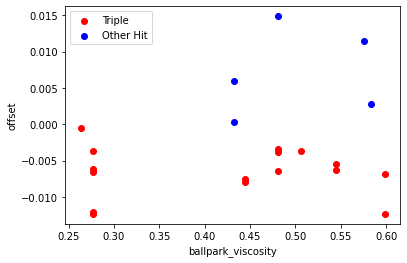

In [178]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]

fig, ax = plt.subplots(1)
x_val = "ballpark_viscosity"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Triple")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="Other Hit")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "weather", "event_type", "batter_multiplier", "pitcher_multiplier",
       "roll", "threshold",
       "fielder_name", "fielder_chasiness",
       "batter_name", "pitcher_name", "batter_mods", "pitcher_mods",
       "batting_team_mods", "pitching_team_mods", "day",  "game_id", "play_count"]].sort_values('offset')


In [296]:
print(dfc[dfc["passed"]]["roll"].min())
print(dfc[~dfc["passed"]]["roll"].max())

0.00033285312312170134
0.9999825875296352
